In [1]:
import pylab as plt
from IPython import display
import numpy as np
import pandas as pd
import scipy.stats as stat
import corner
import copy
import MCMC1
import time
from IPython.display import display, Math, Latex


%matplotlib nbagg
%matplotlib inline
np.random.seed(1)
plt.style.use('ggplot')

## Nested Sampling : Psuedocode
Sample N points $theta_{i},....,theta_{N}$ from prior

Initialize Z = 0 , Xo = 1

Repeat for i = 1,2,...,j;

-   Record the lowest current likelihood as $L_{i}$

-   set $X_{i}$ = exp(-i/N) (Prior mass, decreases with increasing values of L,( 1$\rightarrow$ 0)

-   set $w_{i}$ = $X_{i−1}$−$X_{i}$ or $\frac{X_{i−1}−X_{i}}{2}$ (trapziodal)

-   increment Z by $w_{i}L_{i}$

-   Replace point of lowest likelihood by new one drawn

-      From within $L(theta)>L_{i}$

increment Z by $N^{−1}$($L(theta_{1}$)+...+$L(theta_{N})$)$X_{j}$

In [17]:
def log_like(x):  #Log-Likelihood function  (Simple likelihood function)
    return np.log(2*np.pi)-(x**2)/2

def get_from_p(): #Get a sample from the prior
    return np.array([4*np.random.random()-2])


In [49]:

nest = 900
ZZ = []
for s in range(20):
    objects = []         #Live points
    l_objects =[]        #Log-likelihood of objects
    sample = []          #Store the samples
    logl_sample = []     #Store Log-likelihood of samples
    X_sample = np.zeros(nest)  #Store prior mass


    logWT = np.zeros(nest)  #Store  weight =width*likelihood


    logZ = 0    #-1e300                # SUM(weights)= Z Evidence


    n = 200           # Number of points
    X = 1          # Unit prior mass (Xo = 1)

#-----MCMC Conditions--------------
    runs = 80             #MCMC RUNS
    stepsize = [0.5]      #stepsize
    interval = [(-2,2)]    #FLAT prior interval

###################Sample N pionts from prior##########################
    for i in range(n):
        objects.append(get_from_p())
        l_objects.append(log_like(get_from_p()))
 ## MAIN NS LOOP##
    for i in range(nest):
        # Draw worst object with L* from n points
        worst = np.argmin(l_objects)
    
        #Save worst opbject
        sample.append(objects[worst])
        logl_sample.append(l_objects[worst])
    
        #Save current prior mass
        X_sample[i] = X
        #shrink interval
        X = np.exp(-i/n)
        #width
        w = X_sample[i] - X
        #Calculate weight=width*likelihood
        logwt = w*l_objects[worst]
        logWT[i] = logwt
    
        #Update Evidence Z
        logZ += logwt          #plus(logZ,logwt) 
    
        while True: #Evolve within current worst likelihood L>L* , draw new point under constraint
            s,l,no = MCMC1.metropolis_hasting(log_like,thetai=objects[worst],N=runs,Flat_prior=True,sigma_theta=stepsize,Flat_interval=interval)
            # s-sample,l-loglikelihood,no-no.of accepted (from mcmc)
            if l_objects[worst]<max(l):   # constrain L>L*
                objects[worst] = s[np.argmax(l)]  #Replace worst point with new point
                l_objects[worst] = l[np.argmax(l)]   #Replace the worst likelihood with new one  
                break

    ZZ.append(logZ)
    nest +=1
    

In [62]:
NestZ = np.mean(ZZ)

Text(0,0.5,'NestZ')

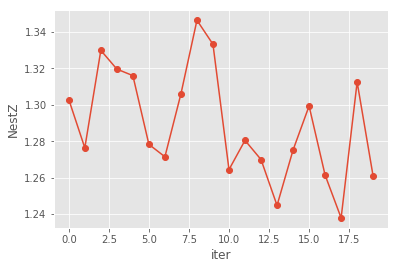

In [67]:
plt.plot(ZZ,'o-')
plt.xlabel('iter')
plt.ylabel('NestZ')

##### In the above plot i was checking for convergence but i didn't run the main nested sampling enough to have a better visual representation because it runs for too long. (I'll work on that)

Text(0.5,0,'mu')

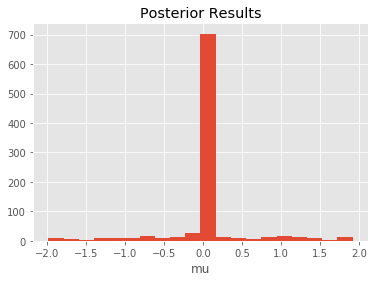

In [61]:
plt.hist(np.array(sample),bins=20);
np.mean(np.exp(np.array(sample)))
plt.title('Posterior Results')
plt.xlabel('mu')


Text(0,0.5,'weights')

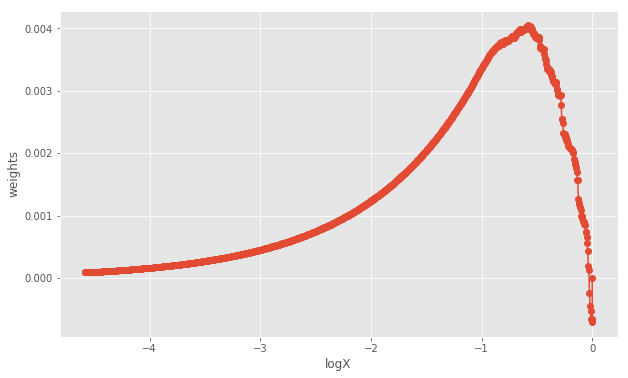

In [63]:
wt = np.exp(logWT-np.max(logWT))
plt.figure(figsize=(10,6))
plt.plot(np.log(X_sample),logWT,'o-')
plt.xlabel('logX')
plt.ylabel('weights')

##### The above plot shows which points contribute to the posterior results.

Text(-2,1,'Area Z')

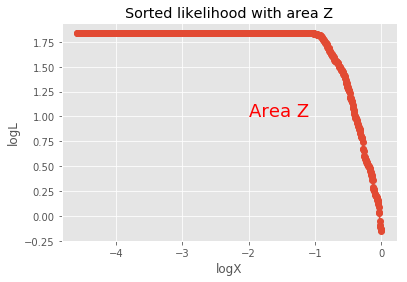

In [64]:
#plt.figure(figsize=(8,8))
plt.plot(np.log(X_sample),logl_sample,'o-')
plt.xlabel('logX')
plt.ylabel('logL')
plt.title('Sorted likelihood with area Z')
plt.text(-2.0,1., 'Area Z', fontsize = 18, color = 'r')

#### The main aim of nested sampling is to get the area under curve which is the evidence

In [56]:
display(Math(r'Z = \frac{1}{\sqrt{2\pi}}\int_{-2}^{2}e^{-x^2/2} dx = 0.954'))

<IPython.core.display.Math object>

In [65]:
print('Zanalytic = {} , NestZ = {}'.format(0.954,NestZ))

Zanalytic = 0.954 , NestZ = 1.2893256338579668


#### This is a crude example as i didn't quote the uncertainty of NestZ, this is because i didn't include the calculation of the H term which is the information. That will be the next update.

- The analytic value and the numerical value of the evidence are quite close with a difference of 0.33. (Better if the uncertanity is provided)